# Proyecto n° 1
## Módulo 6: Técnicas de Análisis de Datos

*Carla Iturriaga Barrios*

*Agosto, 2022*

### Presentación del proyecto.

*Una empresa dedicada a la compra y venta de vehículos usados, donde la **compra es anticipada** y la **venta es por modalidad de remate y venta al mejor postor**, obtiene pérdidas inmediatas a la hora de rematar algunos de sus vehículos, puesto que compran o aseguran el vehículo a un precio más alto del que, finalmente, se vende.*

*A raíz de esto, **la empresa busca asegurar los vehículos a un precio igual o más bajo que el de adjudicación**.*

### Objetivos del proyecto.

1. *Conocer las características que impactan el precio de venta del vehículo y en qué magnitud.*

2. *Predecir el precio de venta de autos usados a partir de los resultados históricos de venta.*

In [59]:
import codigo.dataset as d
import codigo.model as m
##import proj_code.metric as me
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from scipy import stats

### 1. Datos

**Corresponden a una base de datos histórica de las adjudicaciones de vehículos dentro de remates realizados entre 2019 y 2020.**

**Cada registro entrega información sobre el vehículo, tales como marca, modelo, versión, año, kilometraje, origen, etc. Junto al precio asegurado y su precio de venta/adjudicación.**

*En adelante, se utilizaran las funciones definidas en el módulo `dataset.py` para facilitar la gestión y manejo de los datos.*

In [61]:
help(d.load_result)
data = d.load_result()
X, y = data['dataset']

Help on function load_result in module codigo.dataset:

load_result(URL='https://raw.githubusercontent.com/citurriagab/Data_Hist_Resultados/main/RESULTADO_2019_2020.csv')
    Va a buscar los resultados entre 2019 y 2020 de las adjudicaciones de vehículos en remates de la compania. Retorna "X / input" o variables dependientes (características del vehículo) e "y / output" correspondiente al precio de venta.'.

Datos cargados con éxito


IndexError: positional indexers are out-of-bounds

Las dimensiones del *dataset* [Resultados_2019_2020](https://raw.githubusercontent.com/citurriagab/Data_Hist_Resultados/main/RESULTADO_2019_2020.csv) son las siguientes:

*Correspondientes a 5.436 registros de vehículos rematados entre los años definidos anteriormente, presentados en 12 diferentes variables dependientes sumado a la independiente.*

In [ ]:
X.shape, y.shape

((5436, 12), (5436,))

#### Previsualización del dataset 

Al realizar una previsualización de los datos, se obtiene lo siguiente:

In [ ]:
X.head(5)

,FECHA,LOTE,UNIDAD,TIPO,MARCA,MODELO,ANHO,TRACC,COMB,GTIA_MEC,MAG,KILOMETRAJE
0,29-07-2020,1,BFE,STATION WAGON,CHEVROLET,SUBURBAN 4X4 5.3 AUT,2018,4x4,B,NaN,20850000,41090.0
1,29-07-2020,2,PARTICULARES,STATION WAGON,KIA MOTORS,GRAND CARNIVAL EX 2.2 AUT,2018,4x2,D,NaN,13000000,113459.0
2,29-07-2020,3,BFE,STATION WAGON,BMW,X1 SDRIVE20I LUXURY 2.0 AUT,2017,AWD,B,NaN,10403228,32154.0
3,29-07-2020,4,BFE,STATION WAGON,CHEVROLET,CAPTIVA PREMIER 1.5,2020,4x2,B,NaN,8730000,13109.0
4,29-07-2020,5,PARTICULARES,STATION WAGON,SEAT,ATECA 4X4 1.4 AUT,2020,4x4,B,NaN,11000000,2066.0


In [ ]:
y.head(5)

0    23100000
1    14400000
2    14700000
3    13000000
4    13600000
Name: ADJUDIC, dtype: int64

#### Análisis Estadístico

**¿Existen valores nulos o indeterminados en la variable independiente "Adjudicación"**

In [ ]:
y.isna().sum()

0

*No existen registros con información indeterminada en la "adjudicación", es decir, la base de datos consta de todos los vehículos que fueron rematados a un determinado precio de venta*

**Estadística básica de la variable independiente "Adjudicación":**

In [ ]:
y.describe()

count    5.436000e+03
mean     6.206003e+06
std      2.694914e+06
min      3.300000e+05
25%      4.400000e+06
50%      5.900000e+06
75%      7.600000e+06
max      4.550000e+07
Name: ADJUDIC, dtype: float64

*El precio de venta o adjudicación de los vehículos se mueve entre $330.000 y $45.500.000. Lo cual indica desde un principio que existen bienes que la brecha es grande entre el vehículo que se remata más barato en contraste con el más caro.*

*Además, la media y la mediana se distancian en $300.000, con una media mayor que la mediana, **indicando una distribución sesgada a la derecha**.*

**Identificación de valores outliers en variable independiente "Adjudicación"**

Limite inferior:  -400000.0
Limite superior:  12400000.0
Registros sobre el limite sup:  129


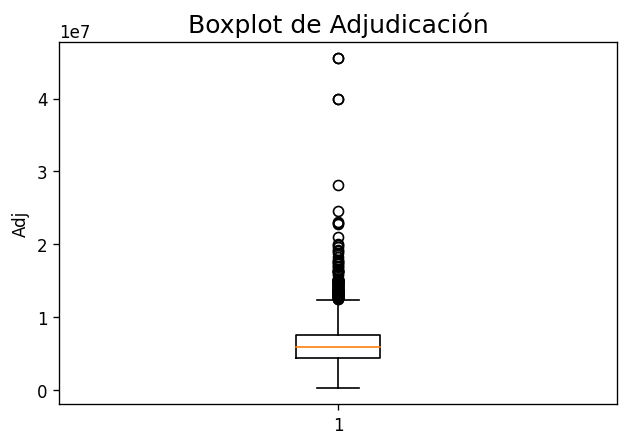

In [ ]:
plt.figure(dpi=120);
plt.boxplot(y)
plt.title('Boxplot de Adjudicación', fontsize=15)
plt.ylabel('Adj', fontsize=10)
plt.text(6.5, -3.25, '')

#cuartiles
q3, q1 = np.percentile(y, [75, 25])
iqr = q3-q1
lim_sup = q3 + (1.5*iqr)
lim_inf = q1 - (1.5*iqr)

# limites
print('Limite inferior: ', lim_inf)
print('Limite superior: ', lim_sup)
print('Registros sobre el limite sup: ', y[y>lim_sup].count())

*De acuerdo al gráfico de boxplot anterior, se obtiene que la variable "Adjudicación" presenta valores atípicos al sobrepasar el precio de venta de $12.400.000, concentrando su movimiento bajo dicho valor.*

*Son **129 las observaciones outliers**, significando el **2,3% de la base total**. Sin embargo, se asume que se debe a autos de lujo o con características especiales que será importante conservar dentro del análisis. Por lo que, **se decide no excluir ni imputar dichas adjudicaciones atípicos**.*

**Distribución de la variable independiente "Adjudicación"**

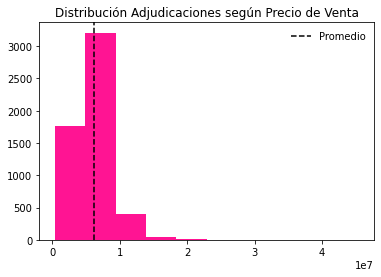

In [ ]:
plt.hist(y, color="deeppink");
plt.axvline(y.mean(), linestyle='--', label='Promedio', color='black');
plt.title('Distribución Adjudicaciones según Precio de Venta');
plt.legend(frameon=False);

**Distribución de la variable independiente "Adjudicación" sin outliers**

*El gráfico de distribución del precio de venta puede ser más claro y excluimos los valores atípicos, sólo para efectos visuales*


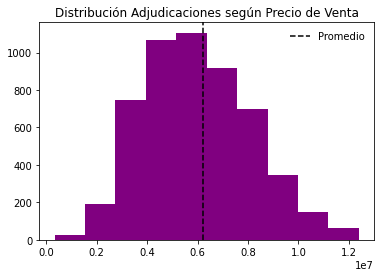

In [ ]:
y1 = y[y<=lim_sup]

plt.hist(y1, color="purple");
plt.axvline(y.mean(), linestyle='--', label='Promedio', color='black');
plt.title('Distribución Adjudicaciones según Precio de Venta');
plt.legend(frameon=False);

*Al excluir los valores outliers de la muestra para visualizar la **distribución de la adjudicación**, el comportamiento parece ser normal, formando una campana de gauss casi perfecta.*

*Sin embargo, como anteriormente se mencionó, la media toma un valor menor que la mediana, presentando un pequeño sesgo hacia la derecha.*

**Preparación de la base de datos: Entrenamiento y Testeo**

*Previo a construir el modelo, se dividirá la base de datos total en dos, ello con la intención de que el modelo conozca y trabaje con determinados datos "de Entrenamiento" y pueda probar su efectividad en datos desconocidos "de Testeo".*

*La base de Entrenamiento se preparará con el 90% de los datos: 4.892 registros, mientras que se probarán resultados con los 544 restantes.*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((4892, 12), (544, 12))

In [ ]:
y_train.shape, y_test.shape

((4892,), (544,))

**Visualizaciones con la Data a Entrenar**

* *Gráfico de dispersión del **Precio de adjudicación/venta** respecto al **Tipo de vehículo** y **Año de fabricación**.*

*La siguiente visualización expresa que mientras más nuevo es el vehículo, más alto es su precio de venta y que tipos como "minibus", "suv/jeep" y "station wagon", son los más caros.*

*Sin embargo, dentro del mismo gráfico, se presentan anomalías indicando que, dentro de los resultados históricos, vehículos de los tipos mencionados anteriormente pueden venderse a un precio más alto sin tener una fecha de fabricación tan cercana, de acuerdo a los colores más oscuros de los puntos.*

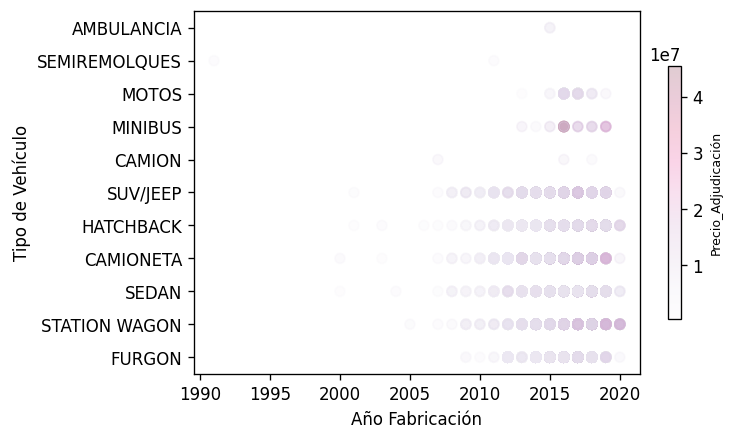

In [ ]:
plt.figure(dpi=120);
CMAP='PuRd'
plt.scatter(X_train['ANHO'], X_train['TIPO'], c=y_train, 
            cmap=CMAP, alpha=.2);
plt.colorbar(orientation='vertical', shrink=0.7).set_label(label='Precio_Adjudicación', size=7.5);
plt.xlabel('Año Fabricación');
plt.ylabel('Tipo de Vehículo');

### 2. Modelo

**Se llevará a cabo la construcción de un modelo de regresión lineal múltiple con las diferentes variables dependientes (características del vehículo) y la variable independiente (precio de adjudicación/venta).**

*En adelante, se utilizaran las funciones definidas en el módulo `model.py` para facilitar la gestión y construcción del modelo.*

In [ ]:
m.reg_lineal

<function codigo.model.reg_lineal(X, y)>

In [ ]:
m.reg_lineal(X_train, y_train)

TypeError: reg_lineal() got an unexpected keyword argument 'random_state'

In [ ]:
(X,y)

(           FECHA  LOTE        UNIDAD           TIPO       MARCA  \
 0     29-07-2020     1           BFE  STATION WAGON   CHEVROLET   
 1     29-07-2020     2  PARTICULARES  STATION WAGON  KIA MOTORS   
 2     29-07-2020     3           BFE  STATION WAGON         BMW   
 3     29-07-2020     4           BFE  STATION WAGON   CHEVROLET   
 4     29-07-2020     5  PARTICULARES  STATION WAGON        SEAT   
 ...          ...   ...           ...            ...         ...   
 5431  10-01-2019   121           BFE          SEDAN      NISSAN   
 5432  10-01-2019   122   AUTOMOTORAS      HATCHBACK      SUZUKI   
 5433  10-01-2019   124   AUTOMOTORAS      HATCHBACK       MAZDA   
 5434  10-01-2019   125   AUTOMOTORAS      HATCHBACK     PEUGEOT   
 5435  10-01-2019   126   AUTOMOTORAS          SEDAN       CHERY   
 
                            MODELO  ANHO TRACC COMB  GTIA_MEC       MAG  \
 0            SUBURBAN 4X4 5.3 AUT  2018   4x4    B       NaN  20850000   
 1       GRAND CARNIVAL EX 2.2 A

In [ ]:
## unidad, tipo, marca, tracc, comb

(X,y)

(           FECHA  LOTE        UNIDAD           TIPO       MARCA  \
 0     29-07-2020     1           BFE  STATION WAGON   CHEVROLET   
 1     29-07-2020     2  PARTICULARES  STATION WAGON  KIA MOTORS   
 2     29-07-2020     3           BFE  STATION WAGON         BMW   
 3     29-07-2020     4           BFE  STATION WAGON   CHEVROLET   
 4     29-07-2020     5  PARTICULARES  STATION WAGON        SEAT   
 ...          ...   ...           ...            ...         ...   
 5431  10-01-2019   121           BFE          SEDAN      NISSAN   
 5432  10-01-2019   122   AUTOMOTORAS      HATCHBACK      SUZUKI   
 5433  10-01-2019   124   AUTOMOTORAS      HATCHBACK       MAZDA   
 5434  10-01-2019   125   AUTOMOTORAS      HATCHBACK     PEUGEOT   
 5435  10-01-2019   126   AUTOMOTORAS          SEDAN       CHERY   
 
                            MODELO  ANHO TRACC COMB  GTIA_MEC       MAG  \
 0            SUBURBAN 4X4 5.3 AUT  2018   4x4    B       NaN  20850000   
 1       GRAND CARNIVAL EX 2.2 A

In [ ]:
## previsualización de train y test
## visualización ilustrativa??? -> scatter de 

## prediccion

#### REVISAR X-> Variables explicativas
#### Y-> variable dependiente

*

metricas

r2_score
mean_squared_error MSE
MSLE 
>>> from sklearn.metrics import mean_squared_log_error
 from sklearn.metrics import mean_absolute_percentage_error
